# Prompt optimization

## Goal
In addition to the main optimizer, __syftr__ includes a Prompt Optimization (PO) mode, which serves as a second-stage optimizer. The typical workflow is:

1. Run the main optimizer to find the Pareto frontier within a specified search space.

2. Apply prompt optimization to further improve accuracy.

In this tutorial, we’ll apply prompt optimization to an existing Pareto frontier and visualize the results to see how accuracy improves.

## Study
For this tutorial, we’ll use a larger study focused on optimizing RAG question-answering flows. It uses several small models on the DR Docs dataset. The Pareto frontier has already been generated and stored in our database.

Since the database state is not bundled with the repository, all necessary information will be displayed through notebook output.

⚠️ This notebook is experimental and part of ongoing work. Expect future updates.

You’re also welcome to try prompt optimization on your own studies.

First, let’s load the example study for prompt optimization and plot its current Pareto frontier. We’ll use the configuration file `example-prompt-optimization-study.yaml.`

In [1]:
import os
from pathlib import Path

# Required to load config files correctly.
current_dir = os.getcwd()
if not str(current_dir).endswith("syftr"):
    parent_dir = Path(os.getcwd()).parent
    os.chdir(parent_dir)

from syftr import api
from syftr.configuration import cfg

example_study = api.Study.from_file(
    cfg.paths.studies_dir / "example-prompt-optimization.yaml"
)
example_study

/Users/nick.volynets/workspace/syftr/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-16 17:34:40,573	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-05-16 17:34:43,766	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Study(name=bench14--small-models--drdocs, remote=False)

Loading Studies: 100%|█████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.49s/it]

data has 998 rows

Running: create_study_stats_table
Running: create_exceptions_stats_table
!!!
!!!

Running: pareto_plot_and_table
data has 518 rows
Running: generate_trial_description_table
data has 13 rows


data has 518 rows
Running: style_pareto_table


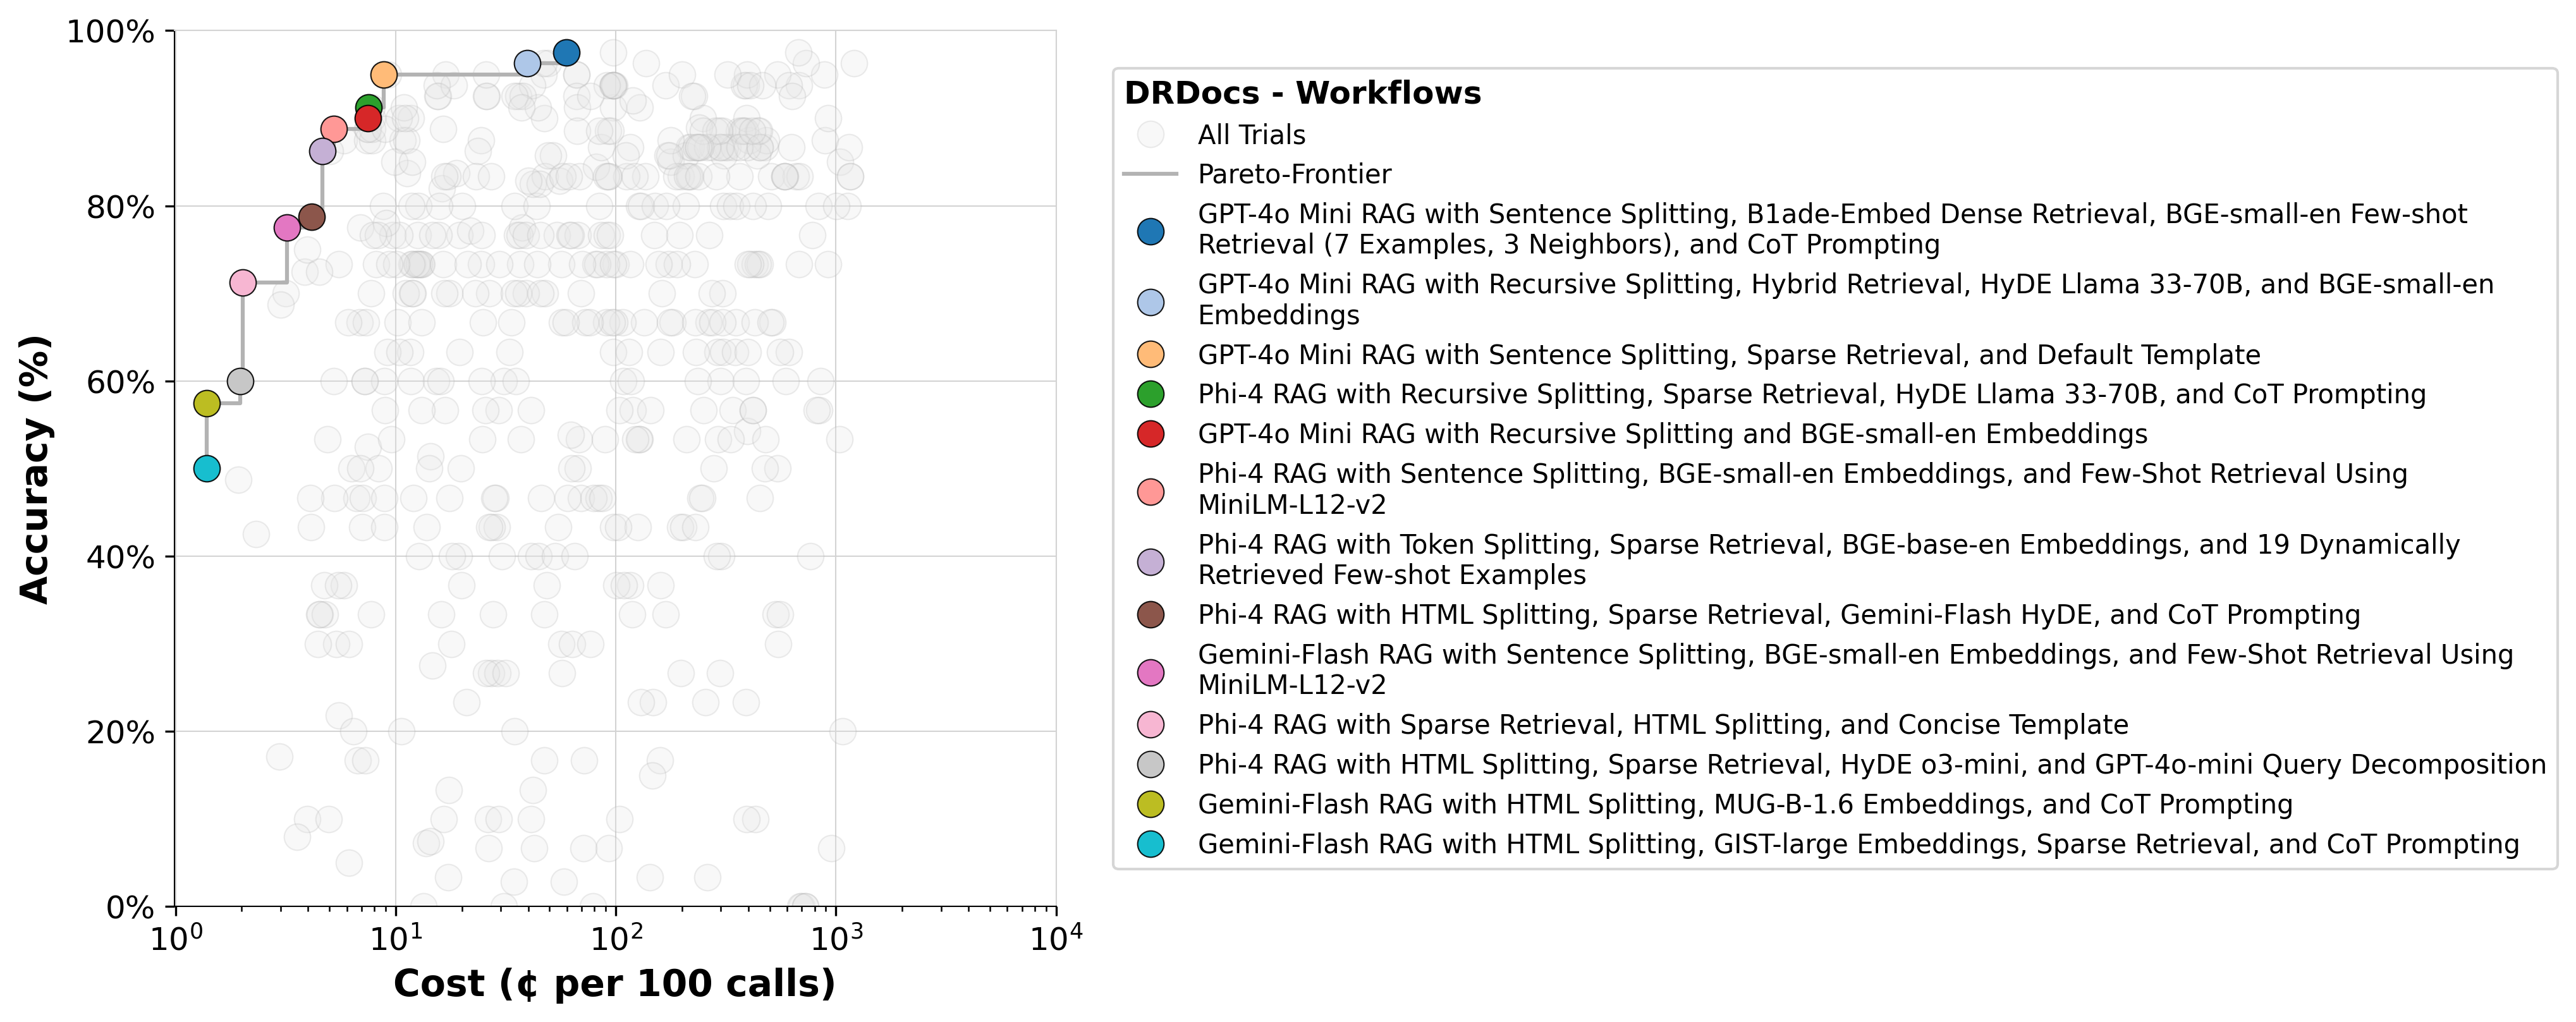

In [2]:
example_study.plot_pareto()

As you can see, the Pareto frontier is quite dense, with a large number of flows represented. The accuracy of these flows ranges from 50% to nearly 100%. It's important to note that only flows with at least 50% accuracy are included in the plot, flows below that threshold are filtered out.

All the flows on the Pareto frontier are RAG flows, which means there's room for further accuracy improvements through prompt optimization.

Currently, we optimize the main Q&A prompt of each flow using the [Trace](https://github.com/microsoft/Trace) library. The prompt optimization is implemented as a standalone script, which is executed from the command line.

Let’s run that script in the next cell.

In [4]:
!uv run python -m syftr.prompt_optimization --study-config studies/example-prompt-optimization.yaml

Using LiteLLM as the default LLM backend.
[I 2025-05-16 17:46:05,148] Loading study config from file studies/example-prompt-optimization.yaml
INFO:syftr:Loading study config from file studies/example-prompt-optimization.yaml
[I 2025-05-16 17:46:05,151] Loading pareto flows for study bench14--small-models--drdocs
INFO:syftr:Loading pareto flows for study bench14--small-models--drdocs
[I 2025-05-16 17:46:36,335] Loaded 123 trials
INFO:syftr:Loaded 123 trials
[I 2025-05-16 17:46:37,668] Creating new study bench14--small-models--drdocs_prompt_optimization for optimized prompts...
INFO:syftr:Creating new study bench14--small-models--drdocs_prompt_optimization for optimized prompts...
[I 2025-05-16 17:46:38,176] Using an existing study with name 'bench14--small-models--drdocs_prompt_optimization' instead of creating a new one.
[I 2025-05-16 17:46:40,298] Running prompt optimization...
INFO:syftr:Running prompt optimization...
[I 2025-05-16 17:46:40,303] Done
INFO:syftr:Done


The PO execution results are stored in the new study `{study_name}_prompt_optimization`. In our case it is `bench14--small-models--drdocs_prompt_optimization`. 

Let's read the results from the database and compare accuracies and costs before and after the optimization.

In [234]:
import pandas as pd
import optuna

RAW_STUDY = "bench14--small-models--drdocs"
PO_STUDY = "bench14--small-models--drdocs_prompt_optimization"

df = optuna.load_study(
    study_name=RAW_STUDY, storage=cfg.postgres.get_optuna_storage()
).trials_dataframe()
df = df[df["values_0"] > 0.5]
pareto_mask = get_pareto_mask(df)
df = df[get_pareto_mask]
df["study_name"] = RAW_STUDY

optimized_df = optuna.load_study(
    study_name=PO_STUDY, storage=cfg.postgres.get_optuna_storage()
).trials_dataframe()
optimized_df = optimized_df.drop_duplicates(
    subset=["user_attrs_parent_number"], keep="last"
)
optimized_df["study_name"] = PO_STUDY

results = pd.merge(
    df,
    optimized_df,
    left_on="number",
    right_on="user_attrs_parent_number",
)
results["Cost mult, x"] = results["values_1_y"] / results["values_1_x"]
results["Acc. improvement"] = (results["values_0_y"] - results["values_0_x"]) * 100
results = results.rename(
    columns={
        "values_0_x": "Accuracy pre-opt",
        "values_1_x": "Cost pre-opt",
        "values_0_y": "Accuracy post-opt",
        "values_1_y": "Cost post-opt",
    }
)
results["Accuracy pre-opt"] *= 100
results["Accuracy post-opt"] *= 100
results = results[
    [
        "Accuracy pre-opt",
        "Cost pre-opt",
        "Accuracy post-opt",
        "Cost post-opt",
        "Acc. improvement",
        "Cost mult, x",
        "user_attrs_flow_name",
        "user_attrs_parent_number",
    ]
]
results

,Accuracy pre-opt,Cost pre-opt,Accuracy post-opt,Cost post-opt,Acc. improvement,"Cost mult, x",user_attrs_flow_name,user_attrs_parent_number
0,77.50,0.000320,83.75,0.000317,6.25,0.991091,RAGFlow,45
1,88.75,0.000522,88.75,0.000523,0.00,1.003042,RAGFlow,58
2,90.00,0.000749,92.50,0.000749,2.50,1.000130,RAGFlow,109
3,97.50,0.005960,97.50,0.005962,0.00,1.000376,RAGFlow,310
4,95.00,0.000882,93.75,0.000878,-1.25,0.996331,RAGFlow,591
5,60.00,0.000197,61.25,0.000191,1.25,0.970208,RAGFlow,813
6,86.25,0.000465,88.75,0.000467,2.50,1.005006,RAGFlow,887
7,96.25,0.003949,95.00,0.004047,-1.25,1.024824,RAGFlow,908
8,57.50,0.000139,57.50,0.000139,0.00,0.999933,RAGFlow,922
9,78.75,0.000416,75.00,0.000416,-3.75,1.001271,RAGFlow,935


In the table above, we can see the costs and accuracies before and after prompt optimization for flows where optimization has been successful. The accuracy improvement (shown in the "Acc. Improvement" row) ranges from -3.75% to 6.25%. While a 6.25% gain is quite solid, the average improvement is slightly lower since we're optimizing flows that are alredy quite accurate.

Also, in many cases, the cost multiplier (shown in the "Cost mult, x" row) is less than 1. This indicates that the optimized prompts are shorter, resulting in fewer LLM tokens being used—and therefore lower costs. Sometimes, optimization can lead to a longer prompts with more instructions which results in a slight cost increase.

If an optimized prompt happens to worsen the latency or performance, we can always fall back to the original prompt to preserve the initial accuracy. 

Now, let’s visualize these results.

Just run the cell below to load plotting code.

In [235]:
# DO NOT EDIT, this code was adopted from insights notebook and should be eventually reworked.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scratch.insights.insights import (
    title_by_rag_mode,
    plot_pareto_plot,
    get_pareto_square_points,
    grey_edge_color,
    get_comparison_accuracies,
    get_baselines,
    descriptive_name,
    wrap,
)

OBJECTIVE_2 = "Cost"
discrete_cmap = plt.get_cmap("tab20")


def plot_pareto_plot(
    df_pareto_desc, study_name, df_trials=None, color_dict=None, ax=None
):
    df_pareto_desc = df_pareto_desc.sort_values(
        ["Accuracy", OBJECTIVE_2], ascending=[False, True]
    )
    new_pareto = df_pareto_desc[df_pareto_desc["pareto"]]
    px, py = get_pareto_square_points(new_pareto[OBJECTIVE_2], new_pareto["Accuracy"])

    is_subplot = ax is not None
    if ax is None:
        fig, ax = plt.subplots(dpi=300, figsize=(8, 5))
    else:
        fig = None

    # plot all historical trials
    if df_trials is not None:
        ax.plot(
            df_trials["values_1"],
            df_trials["values_0"],
            "o",
            color="gray",
            markeredgecolor=grey_edge_color,
            markeredgewidth=0.5,
            alpha=0.5,
            label=f"All Trials ({len(df_trials)})",
        )

    # plot sota comparisons as horizontal lines
    comparisons = get_comparison_accuracies([study_name])
    linestyles = ["--", "-.", ":", "-"]
    for i, (_, (_, title, accuracy)) in enumerate(comparisons.iterrows()):
        if np.isnan(accuracy):
            continue
        linestyle = linestyles[i % len(linestyles)]
        ax.axhline(
            accuracy,
            color=grey_edge_color,
            linestyle=linestyle,
            linewidth=0.5,
            label=wrap(title, 100),
        )

    if not "prompt_optimization" in study_name:
        ax.plot(px, py, ":", color="gray", label="Pareto Frontier before PO")
    else:
        ax.plot(px, py, "-", color="darkblue", label="Pareto Frontier after PO")
    labels = df_pareto_desc["Title"].unique()
    for i, label in enumerate(labels):
        if "prompt_optimization" in study_name:
            if color_dict is None:
                color = discrete_cmap(i / max(10, len(labels)))
            else:
                color = color_dict[label]
            filter = df_pareto_desc["Title"] == label
            ax.plot(
                df_pareto_desc.loc[filter, OBJECTIVE_2],
                df_pareto_desc.loc[filter, "Accuracy"],
                "o",
                color=color,
                markeredgewidth=0.5,
                markeredgecolor=(0, 0, 0, 0.9),
                label=wrap(label, 50 if is_subplot else 100),
            )

    ax.set_xlabel(descriptive_name("values_1"))
    ax.set_ylabel(descriptive_name("values_0"))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.tick_params(axis="both", which="major", labelsize=8, width=1, length=6)
    ax.tick_params(axis="both", which="minor", labelsize=8, width=1, length=3)
    ax.set_xscale("log")
    ax.grid(True, which="major", linestyle="-", color="lightgrey", linewidth=0.5)
    ax.spines["top"].set_linewidth(False)
    ax.spines["top"].set_color("lightgrey")
    ax.spines["top"].set_linewidth(0.5)

    ax.spines["right"].set_linewidth(False)
    ax.spines["right"].set_color("lightgrey")
    ax.spines["right"].set_linewidth(0.5)

    ax.spines["bottom"].set_linewidth(0.5)
    ax.spines["left"].set_linewidth(0.5)
    ax.set_xlabel(ax.get_xlabel(), fontweight="bold", fontsize=8)
    ax.set_ylabel(ax.get_ylabel(), fontweight="bold", fontsize=8)

    if is_subplot:
        ax.legend(loc="lower right", fontsize=8)
    else:
        ax.legend(loc="lower right", fontsize=8)
    return fig


def plot_all_paretos(df, study_names, plot_title):
    n = len(study_names)
    ncols = int(np.ceil(np.sqrt(n)))
    nrows = int(np.ceil(n / ncols))
    fig = plt.figure(figsize=(1 + 6 * ncols / 2, 1 + 5 * nrows / 3))
    axes = fig.add_axes([0, 0, 1, 2])
    paretos = []
    for k, study_name in enumerate(study_names):
        df_trials = df[df["study_name"] == study_name]
        df_pareto = df_trials.sort_values(
            ["values_0", "values_1"], ascending=[False, True]
        )
        df_pareto = df_pareto.rename(
            columns={"values_0": "Accuracy", "values_1": OBJECTIVE_2}
        )
        if len(df_pareto) > 0:
            df_pareto["Title"] = df_pareto.apply(title_by_rag_mode, axis=1)
        else:
            df_pareto["Title"] = ""
        paretos.append(df_pareto)

    df_all_paretos = pd.concat(paretos, axis=0, ignore_index=True)
    unique_titles = df_all_paretos["Title"].unique()
    color_dict = {}
    for i, title in enumerate(unique_titles):
        color_dict[title] = discrete_cmap(i / max(10, len(unique_titles)))

    for k, (study_name, df_pareto) in enumerate(zip(study_names, paretos)):
        df_trials = df[df["study_name"] == study_name]
        plot_pareto_plot(
            df_pareto, study_name, df_trials, color_dict=color_dict, ax=axes
        )
        i = k // ncols
        j = k % ncols
        axes.set_xlabel("Cost (¢ per 100 calls))")
        axes.set_ylabel("Accuracy (%)")
    axes.set_title(plot_title)
    return fig

Next cell does all preprocessing and filtering for plotting so that the prompt optimization look similar to the original plot.

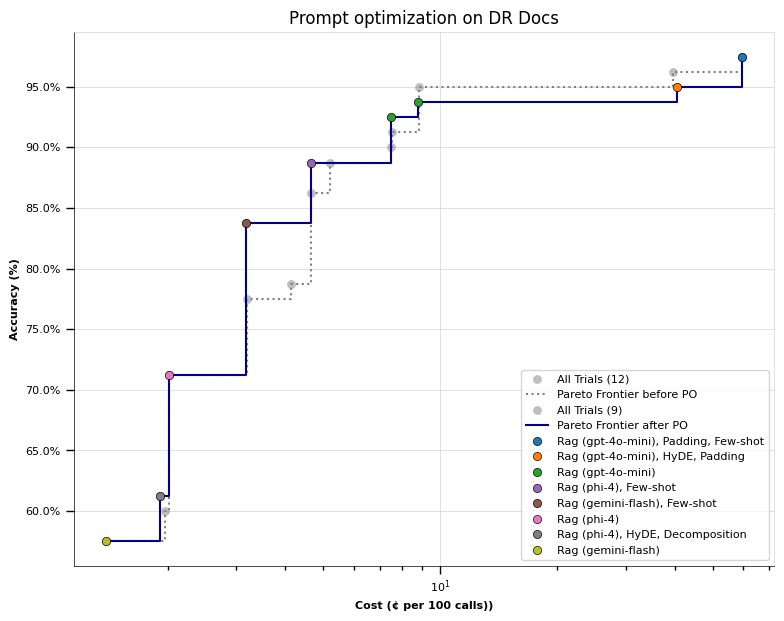

In [236]:
# Replace results in initial df with results from PO df for visualization.
updated_df = df.copy()
for _, r in optimized_df.iterrows():
    parent_number = r["user_attrs_parent_number"]
    updated_df.loc[updated_df["number"] == parent_number, "values_0"] = r["values_0"]
    updated_df.loc[updated_df["number"] == parent_number, "values_1"] = r["values_1"]
    updated_df.loc[updated_df["number"] == parent_number, "parent_number"] = (
        parent_number
    )

updated_df.study_name = PO_STUDY
updated_df["pareto"] = get_pareto_mask(updated_df)
updated_df = updated_df[updated_df["pareto"]]
df.loc[:, "pareto"] = True
full_df = pd.concat([df, updated_df])
full_df["values_1"] *= 10000  # Scaling.
fig = plot_all_paretos(full_df, [RAW_STUDY, PO_STUDY], "Prompt optimization on DR Docs")

The gray line represents the Pareto frontier before prompt optimization, while the blue line shows the frontier after PO.

As seen in the table, some flows move upward on the plot, indicating an improvement in accuracy. This  confirms that prompt optimization has successfully enhanced performance for certain flows.

Note: These results are raw—we haven’t yet filtered or replaced any flows where the new prompts resulted in lower accuracy.